---

# Laboratório de Inovação e Automação 1
2023/1 | 46M34 | Sala 200 CAE

---
## Aula 01 - fast.ai
**Aluno**: Danilo Rodrigues Torchio  
**Matrícula**: 201400371

---

# Is it a bird?

Serão executadas as seguintes etapas neste notebook:

1.   Usar o serviço DuckDuckGo para procurar imagens de pássaros.
2.   Usar o serviço DuckDuckGo para procurar imagens de florestas.
3.   Usar uma rede-neural pré-treinada para reconhecer estes dois grupos.
4.   Usar este modelo para reconhecer fotos em um destes dois grupos

In [1]:
# Certifica que as bibliotecas estão instaladas e atualizads
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.7 MB/s eta 0:00:00


# Passo 1: Baixar imagens de passaros e florestas

In [2]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from time import sleep

In [3]:
def search_images(term, max_images=200):
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
url_bird = search_images('bird photos', max_images=1)[0]
url_forest = search_images('forest photos', max_images=1)[0]

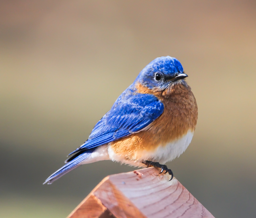

In [5]:
dest_bird = 'bird.jpg'
download_url(url_bird, dest_bird, show_progress=False)

im = Image.open(dest_bird)
im.to_thumb(256, 256)

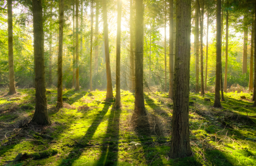

In [6]:
dest_forest = 'forest.jpg'
download_url(url_forest, dest_forest, show_progress=False)

im = Image.open(dest_forest)
im.to_thumb(256, 256)

In [7]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  sleep(10) # Pausa entre as pesquisas para não sobrecarregar o serviço
  download_images(dest, urls=search_images(f'{o} sun photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photo'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

# Passo 2: Treinar o modelo

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

16

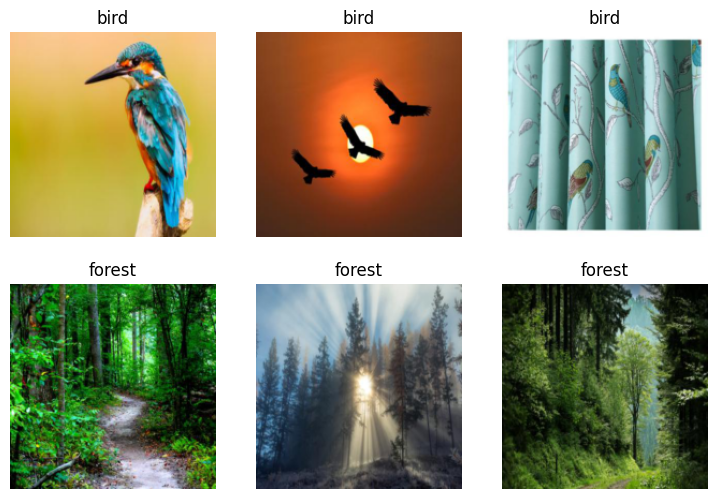

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.3MB/s]


# Passo 3: Testar o modelo

In [11]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [12]:
is_forest,_,_probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_forest}.")
print(f"Probability it's a forest: {probs[0]:.4f}")

This is a: forest.
Probability it's a forest: 1.0000
